In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT/"src"))

# Startup checks
from config import CLEAN_FILE
from startup_checks import ensure_project_dirs, check_required_data

ensure_project_dirs()
check_required_data(CLEAN_FILE)

2025-12-19 17:10:42.624165: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-19 17:10:42.667531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-19 17:10:43.682896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from config import TEXT_COL, LABEL_COL, MAX_LEN, VOCAB_SIZE, OOV_TOKEN, RANDOM_STATE
from preprocess import load_and_clean_data, text_to_padded_sequences
from utils import reset_tf_state, build_label_mappings, encode_labels, evaluate_and_plot
from artifacts_utils import save_label_artifacts, save_tokenizer, save_latest_metrics
from models import build_bilstm_model

import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [3]:
# load dataset
df = load_and_clean_data(CLEAN_FILE, basic_clean=False, clean_label=False)    # Load cleaned dataset generated in Notebook 01 (labels already normalized)

In [4]:
# Label encoding
label_order, label_to_id, id_to_label = build_label_mappings(df[LABEL_COL])

print(f"label_order: {label_order}, {type(label_order)}")
print(f"label_to_id: {label_to_id}, {type(label_to_id)}")
print(f"id_to_label: {id_to_label}, {type(id_to_label)}")

label_order: ['positive', 'negative', 'neutral'], <class 'list'>
label_to_id: {'positive': 0, 'negative': 1, 'neutral': 2}, <class 'dict'>
id_to_label: {0: 'positive', 1: 'negative', 2: 'neutral'}, <class 'dict'>


In [5]:
# Save lable map artifacts as label_map.json
save_label_artifacts(
    label_order=label_order,
    label_to_id=label_to_id,
    id_to_label=id_to_label
)

Label artifacts are saved in /home/tl/stock-news-sentiment-tensorflow/artifacts/preprocessing/label_map.json


In [6]:
# Split dataset into train, validation and test set
X = df[TEXT_COL].values
y = df[LABEL_COL].values
y_encoded = encode_labels(y, label_to_id)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    stratify=y_encoded,
    test_size=0.15,    # train 85% | test 15%
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    stratify=y_train,
    test_size=0.15/0.85,    # train ~70% | validation ~15%
    random_state=RANDOM_STATE
)

print(f"X_train = {len(X_train)}")
print(f"X_val = {len(X_val)}")
print(f"X_test = {len(X_test)}")

X_train = 4088
X_val = 877
X_test = 877


In [7]:
# Word-level tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)    # Build vocabulary

print(f"Vocabularies = {len(tokenizer.word_index)}")

Vocabularies = 9441


In [8]:
# Save tokenizer as tokenizer.json
save_tokenizer(tokenizer)

Tokenizer is saved to /home/tl/stock-news-sentiment-tensorflow/artifacts/preprocessing/tokenizer.json


In [9]:
# Convert to padded sequences
X_train_pad, X_train_seq = text_to_padded_sequences(tokenizer, X_train, MAX_LEN)
X_val_pad, X_val_seq = text_to_padded_sequences(tokenizer, X_val, MAX_LEN)
X_test_pad, X_test_seq = text_to_padded_sequences(tokenizer, X_test, MAX_LEN)

print("X_train_seq len: ", len(X_train_seq[0]))    # Sequence length
print("X_train_seq:\n", X_train_seq[0][:20])    # First 20 tokens
print("X_train_pad.shape: ", X_train_pad.shape)
print("X_train_pad:\n", X_train_pad[0])

X_train_seq len:  13
X_train_seq:
 [2, 160, 2050, 38, 1522, 718, 4, 283, 296, 14, 568, 5, 1523]
X_train_pad.shape:  (4088, 50)
X_train_pad:
 [   2  160 2050   38 1522  718    4  283  296   14  568    5 1523    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [10]:
# Compute class weights due to imbalanced dataset
classes = np.unique(y_train)

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, class_weights_array))
class_weights

{np.int32(0): np.float64(1.051440329218107),
 np.int32(1): np.float64(2.2635658914728682),
 np.int32(2): np.float64(0.6222222222222222)}

In [11]:
# Build Bidrectional LSTM model
reset_tf_state(RANDOM_STATE)

# baseline hyperparameters config
cfg = {
    "embedding_dim": 100,
    "lstm_units": 64,
    "dropout": 0.3,
    "lr": 1e-3,
    "dense_units": 64,
    "dense_dropout": 0.3,
    "batch_size": 32,
}

model = build_bilstm_model(
    cfg,
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    classes_qty=len(label_order),
    verbose=True
)

model.summary()

I0000 00:00:1766135445.129969   61379 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


embedding_dim: 100
lstm_units: 64
dropout: 0.3
lr: 0.001
dense_units: 64
dense_dropout: 0.3
batch_size: 32


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092,931 (4.17 MB)

 Trainable params: 1,092,931 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
# EarlyStopping on validation loss for stable model selection
es = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=30,
    batch_size=cfg["batch_size"],
    class_weight=class_weights,
    callbacks=[es]
)

Epoch 1/30


2025-12-19 17:10:45.393491: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4812 - loss: 1.0393 - val_accuracy: 0.6306 - val_loss: 0.8968
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7285 - loss: 0.6792 - val_accuracy: 0.6442 - val_loss: 0.8040
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8518 - loss: 0.3260 - val_accuracy: 0.6420 - val_loss: 0.9538
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8843 - loss: 0.2640 - val_accuracy: 0.6830 - val_loss: 1.1668
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9097 - loss: 0.1834 - val_accuracy: 0.6727 - val_loss: 1.2135
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9154 - loss: 0.1722 - val_accuracy: 0.6363 - val_loss: 1.5682


----------------- Metrics -----------------
 val_macro_f1  val_acc  val_loss
     0.605343 0.644242  0.803978
-------------------------------------------

              precision    recall  f1-score   support

    positive       0.67      0.66      0.67       278
    negative       0.38      0.55      0.45       129
     neutral       0.75      0.66      0.70       470

    accuracy                           0.64       877
   macro avg       0.60      0.62      0.61       877
weighted avg       0.67      0.64      0.65       877



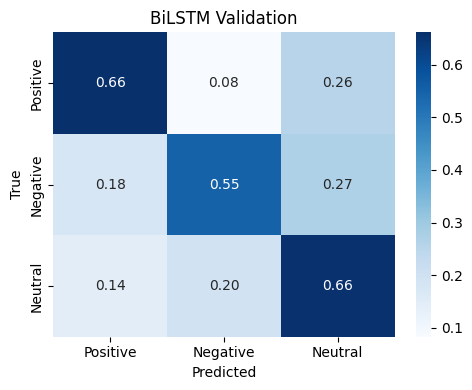

In [13]:
# Evaluate validation set, display classification report and plot confusion matrix
val_metrics = evaluate_and_plot(model, X_val_pad, y_val, label_order, split_name="val", title="BiLSTM Validation")    # Default show classification report and confusion matrix

In [14]:
notebook_name = "02_bilstm_baseline_model"

# Save validation metrics to artifacts/result
val_metrics["split"] = "val"
val_metrics["model"] = "BiLSTM"
val_metrics["stage"] = "02-BiLSTM Baseline"

save_latest_metrics(
    metrics=val_metrics,
    filename=f"{notebook_name}_validation"
)

Metrics are saved in /home/tl/stock-news-sentiment-tensorflow/artifacts/results/02_bilstm_baseline_model_validation.json


----------------- Metrics -----------------
 test_macro_f1  test_acc  test_loss
      0.642306  0.677309   0.751313
-------------------------------------------

              precision    recall  f1-score   support

    positive       0.71      0.71      0.71       278
    negative       0.40      0.64      0.49       129
     neutral       0.80      0.67      0.73       470

    accuracy                           0.68       877
   macro avg       0.64      0.67      0.64       877
weighted avg       0.71      0.68      0.69       877



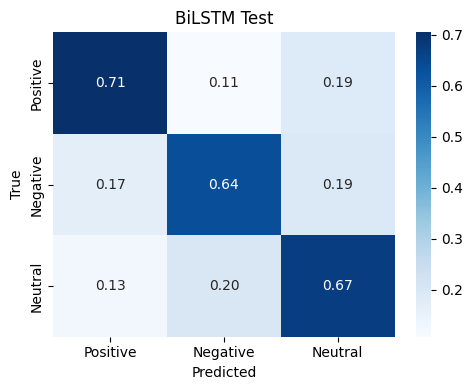

In [15]:
# Evaluate test set, display classification report and plot confusion matrix
test_metrics = evaluate_and_plot(model, X_test_pad, y_test, label_order, split_name="test", title="BiLSTM Test")

In [16]:
# Save test metrics to artifacts/result
test_metrics["split"] = "test"
test_metrics["model"] = "BiLSTM"
test_metrics["stage"] = "02-BiLSTM Baseline"

save_latest_metrics(
    metrics=test_metrics,
    filename=f"{notebook_name}_test"
)

Metrics are saved in /home/tl/stock-news-sentiment-tensorflow/artifacts/results/02_bilstm_baseline_model_test.json


## Summary - BiLSTM Baseline Model

### Objective
Build a neural baseline using sequence modeling to capture contextual information beyond lexical features.

### Work performed
- Split the dataset into **train/validation/test = 70%/15%/15%** using stratified sampling
- Implemented a **BiLSTM based sentiment classifier** with
  - Tokenizer + padded sequences
  - Embedding layer
  - Bidirectional LSTM encoder
  - Dense classification head
- Trained with **EarlyStopping (monitor=val_loss)** to prevent overfitting
- Computed class weights to mitigate class imbalance

### Key decisions
- Reserved the validation set for EarlyStopping monitoring
- Used **macro F1-score** for fair comparison across sentiment classes

### Results
- **Macro F1-score (validation)**: Automatically saved in **artifacts/results/02_bilstm_baseline_model_validation.json**
- **Macro F1-score (test)**: Automatically saved in **artifacts/results/02_bilstm_baseline_model_test.json**

### Artifacts produced
- Tokenizer artifacts: **artifacts/preprocessing/tokenizer.json**
- Label mapping artifacts: **artifacts/preprocessing/label_map.json**
- Validation and test evaluation metrics

### Takeaway
The BiLSTM model slightly outperforms the classical baseline on the test set, demonstrating the benefit of sequence modeling while highlighting the strength of lexical baselines on short texts.